## Something to look up from output

- [x] batch_size
    - `samples_per_gpu` in config: please refer to https://github.com/open-mmlab/mmsegmentation/blob/master/mmseg/datasets/builder.py#L78
- [x] load model from intermediate step

In [1]:
GPU_NUMBER = 4
DEVICE = 'cpu' if GPU_NUMBER < 0 else 'cuda:{}'.format(GPU_NUMBER)

In [2]:
import sys
sys.path.append("../")

In [3]:
import torch, torchvision
import mmseg
import mmcv

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import glob
import json
import numpy as np
from PIL import Image

from semanticsegmentation.class_names import *

from mmseg.datasets import build_dataset, build_dataloader
from mmseg.models import build_segmentor
from mmseg.apis import init_segmentor, inference_segmentor, single_gpu_test, multi_gpu_test

In [4]:
cfg = mmcv.Config.fromfile('../experiments/config_standfordbackground.py')

In [5]:
img_file = '../sample/demo.png'

In [6]:
def _plot_results(raw_image, segmentor_results):
    img = mmcv.imread(raw_image)
    
    seg = segmentor_results[0]

    color_seg = np.zeros(img.shape, dtype=np.uint8)

    print("Color Segmentation Mask Shape: ", color_seg.shape)

    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # convert to BGR (it is required to convert segmentation mask to BGR to match raw image channel order)
    color_seg = color_seg[..., ::-1]

    # Overlay segmentation mask on to original image
    img_overlay = img * 0.5 + color_seg * 0.5
    img_overlay = img_overlay.astype(np.uint8)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

    ax1.imshow(mmcv.bgr2rgb(img))
    ax2.imshow(mmcv.bgr2rgb(img_overlay))
    ax3.imshow(mmcv.bgr2rgb(color_seg))

    ax1.set_title("Raw Image")
    ax2.set_title("Overlay Prediction")

    

    # create a patch (proxy artist) for every color 
    patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                              label=classes[i]) for i in range(8)]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
               fontsize='large')

    plt.show()

## Let's see predictions under different training steps.

In [7]:
checkpts_ = torch.load("../work_dirs/debug_v1.0.0/iter_25.pth", map_location=torch.device("cpu"))

In [8]:
checkpts_["meta"]

{'iter': 25,
 'epoch': 1,
 'CLASSES': ('sky',
  'tree',
  'road',
  'grass',
  'water',
  'bldg',
  'mntn',
  'fg obj'),
 'PALETTE': [[128, 128, 128],
  [129, 127, 38],
  [120, 69, 125],
  [53, 125, 34],
  [0, 11, 123],
  [118, 20, 12],
  [122, 81, 25],
  [241, 134, 51]],
 'hook_msgs': {'last_ckpt': '/data-non-pii-share/rd_ai/mohan/mmsegmentation_demo/work_dirs/debug_v1.0.0/iter_20.pth'},
 'mmcv_version': '1.2.6',
 'time': 'Tue Feb 16 16:23:34 2021'}

Color Segmentation Mask Shape:  (512, 1024, 3)


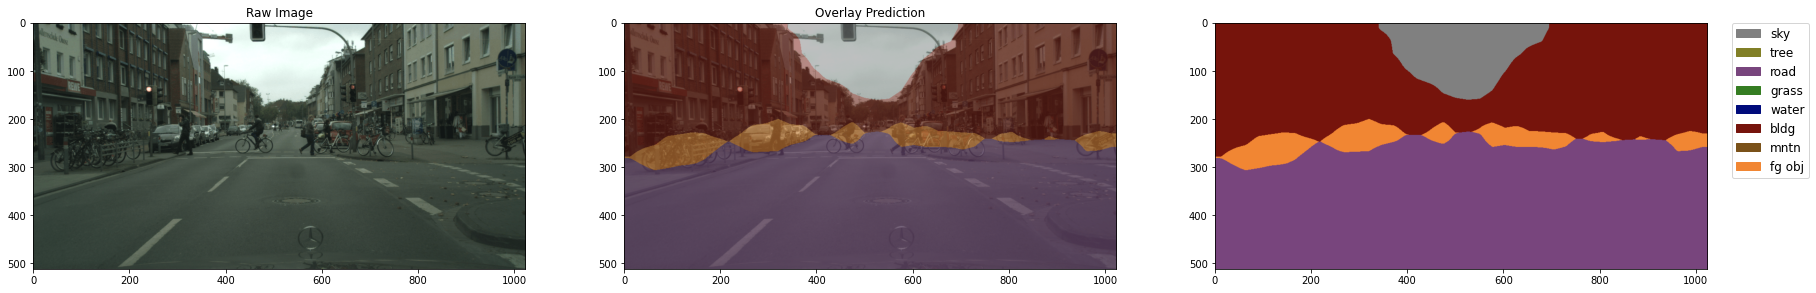

In [9]:
model = init_segmentor(cfg, "../work_dirs/debug_v1.0.0/iter_25.pth", device=DEVICE)
result = inference_segmentor(model, img_file)
_plot_results(img_file, result)

Color Segmentation Mask Shape:  (512, 1024, 3)


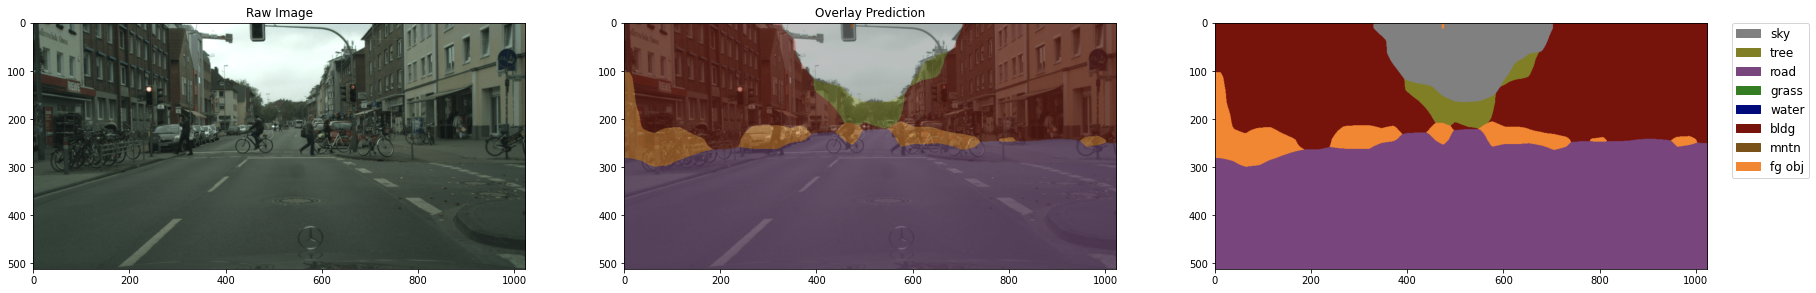

In [10]:
model = init_segmentor(cfg, "../work_dirs/debug_v1.0.0/iter_50.pth", device=DEVICE)
result = inference_segmentor(model, img_file)
_plot_results(img_file, result)

Color Segmentation Mask Shape:  (512, 1024, 3)


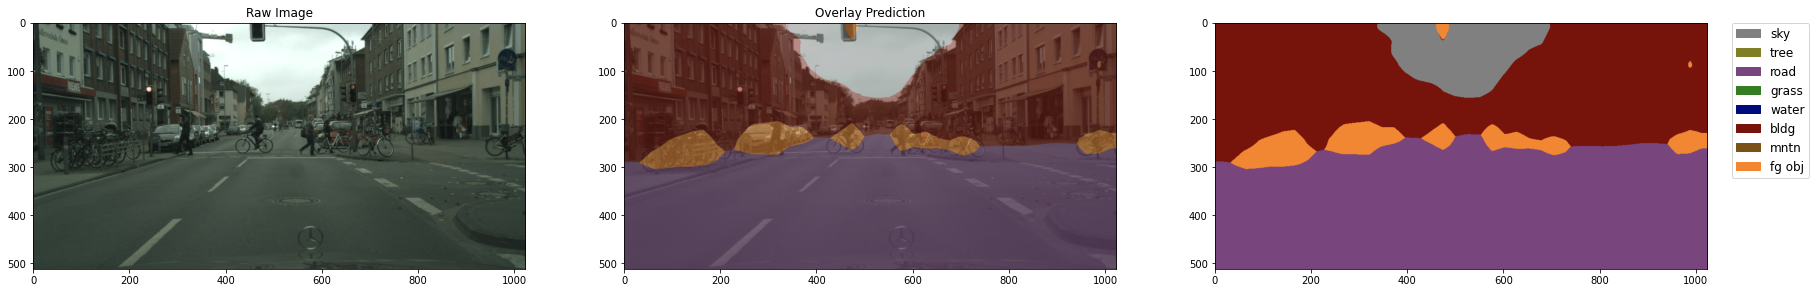

In [11]:
model = init_segmentor(cfg, "../work_dirs/debug_v1.0.0/iter_75.pth", device=DEVICE)
result = inference_segmentor(model, img_file)
_plot_results(img_file, result)

Color Segmentation Mask Shape:  (512, 1024, 3)


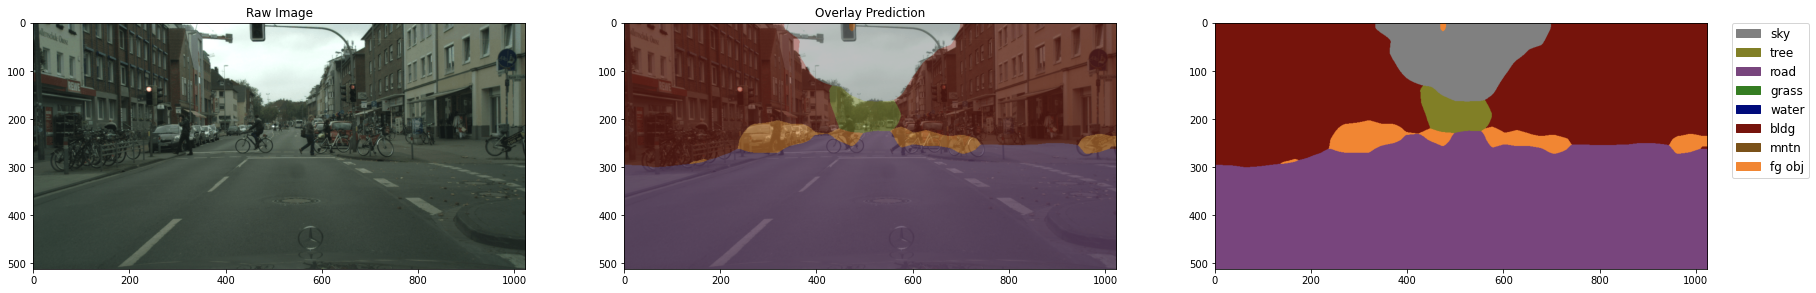

In [12]:
model = init_segmentor(cfg, "../work_dirs/debug_v1.0.0/iter_100.pth", device=DEVICE)
result = inference_segmentor(model, img_file)
_plot_results(img_file, result)

## Analyze training log

In [13]:
training_history = []
with open("../work_dirs/debug_v1.0.0/None.log.json", "r") as f:
    for line in f.readlines():
        training_history.append(json.loads(line))

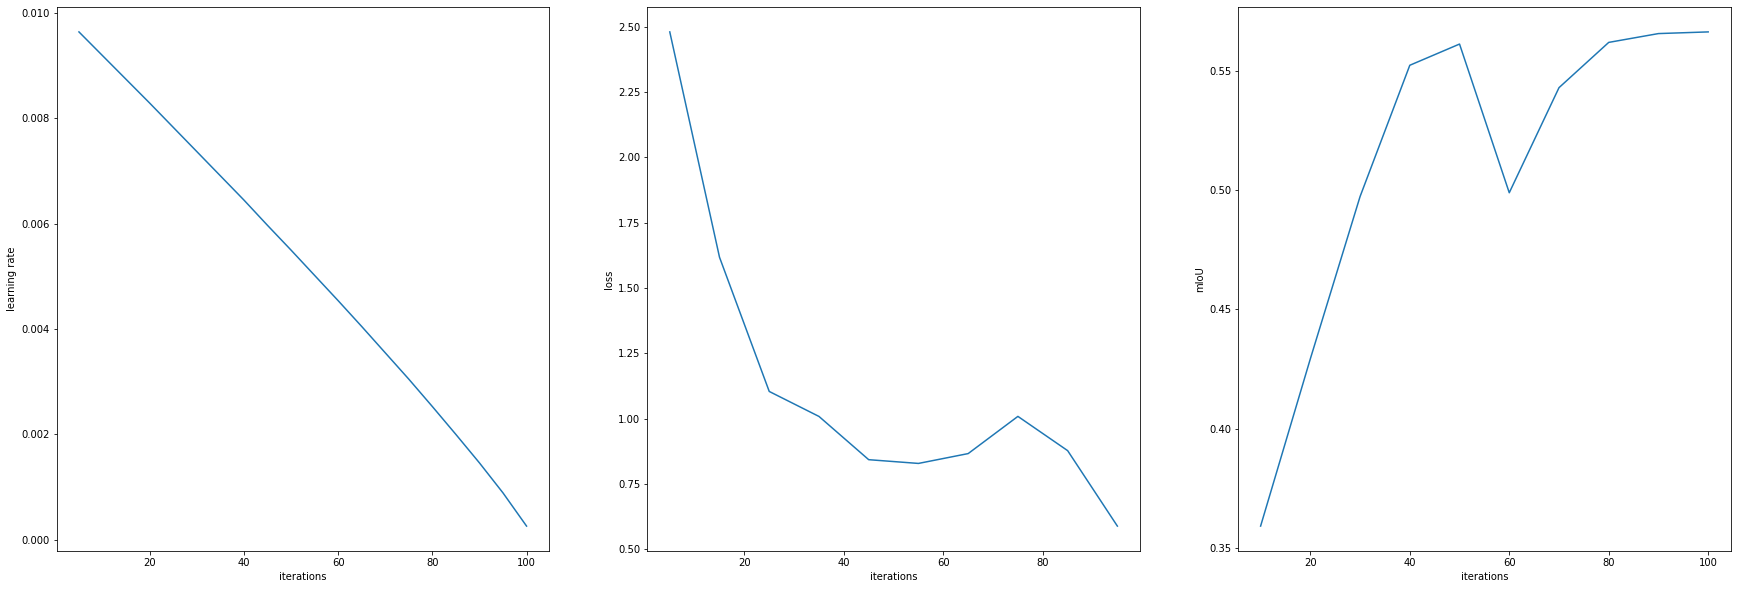

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

ax1.plot([v["iter"] for v in training_history[1:]], [v["lr"] for v in training_history[1:]] )
ax2.plot([v["iter"] for v in training_history[1:] if v["mode"] == "train"], [v["loss"] for v in training_history[1:] if v["mode"] == "train"] )
ax3.plot([v["iter"] for v in training_history[1:] if v["mode"] == "val"], [v["mIoU"] for v in training_history[1:] if v["mode"] == "val"])

ax1.set_xlabel("iterations")
ax2.set_xlabel("iterations")
ax3.set_xlabel("iterations")

ax1.set_ylabel("learning rate")
ax2.set_ylabel("loss")
ax3.set_ylabel("mIoU")

plt.show()